In [1]:
import matplotlib.pyplot as plt

In [ ]:
import numpy as np

rng = np.random.RandomState(5)
figures_path = "../Figures/"

In [2]:
def f(x):
    return x * np.cos(1.5 * x)


# Define latex function
latex_func = r"$f(x) = x \cos(1.5x)$"


x_min = 0
x_max = 10
n_true = 1_000
n_test = 100
n_train = 10
s = 0.000005  # noise variance.

X_true = np.linspace(start=x_min, stop=x_max, num=n_true)
y_true = f(X_true)

X_test = np.linspace(start=x_min, stop=x_max, num=n_test).reshape(-1, 1)
y_test = f(X_test)

X_train = (rng.rand(n_train) * x_max).reshape(-1, 1)
y_train = f(X_train) + s * rng.randn(n_train).reshape(-1, 1)
X_train.shape, y_train.shape

((10, 1), (10, 1))

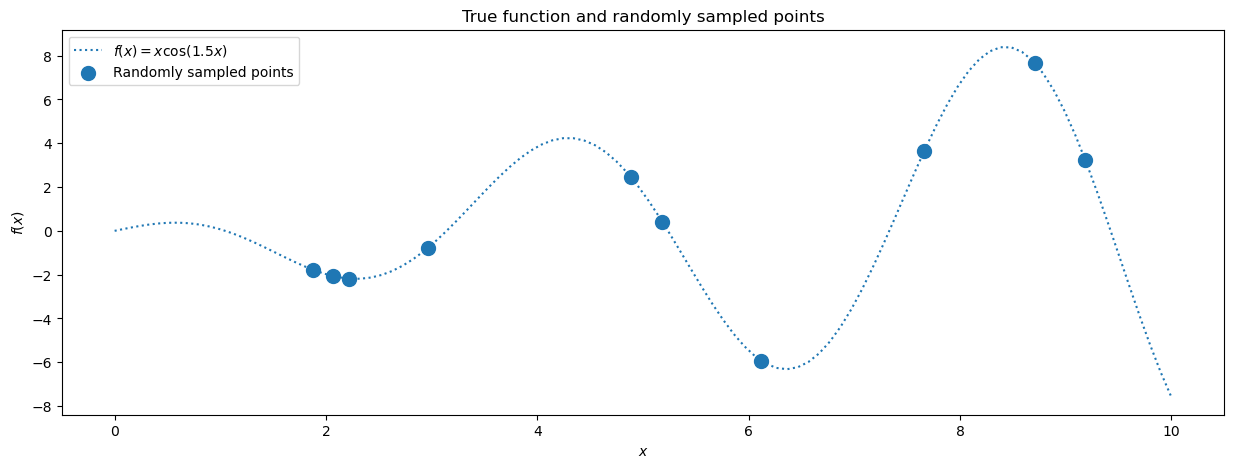

In [3]:
plt.figure(figsize=(15, 5))
plt.plot(X_test, y_test, label=latex_func, linestyle="dotted")
plt.scatter(X_train, y_train, label="Randomly sampled points", s=100)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.title("True function and randomly sampled points")
plt.savefig(figures_path + "true_function.pdf")

In [4]:
# Define the kernel
def kernel(a, b):
    """GP squared exponential kernel function"""
    kernelParameter_l = 0.5
    kernelParameter_sigma = 1.0
    sqdist = (
        np.sum(a**2, axis=1).reshape(-1, 1) + np.sum(b**2, 1) - 2 * np.dot(a, b.T)
    )
    # np.sum( ,axis=1) means adding all elements columnly; .reshap(-1, 1) add one dimension to make (n,) become (n,1)
    return kernelParameter_sigma * np.exp(-0.5 * (1 / kernelParameter_l) * sqdist)

In [5]:
K_train = kernel(X_train, X_train)
K_test = kernel(X_test, X_test)
K_cross = kernel(X_train, X_test)

L = np.linalg.cholesky(K_train + s * np.eye(n_train))
Lk = np.linalg.solve(L, K_cross)
mean_prediction = np.dot(Lk.T, np.linalg.solve(L, y_train)).ravel()
var_prediction = np.diag(K_test) - np.sum(Lk**2, axis=0)
std_prediction = np.sqrt(var_prediction)

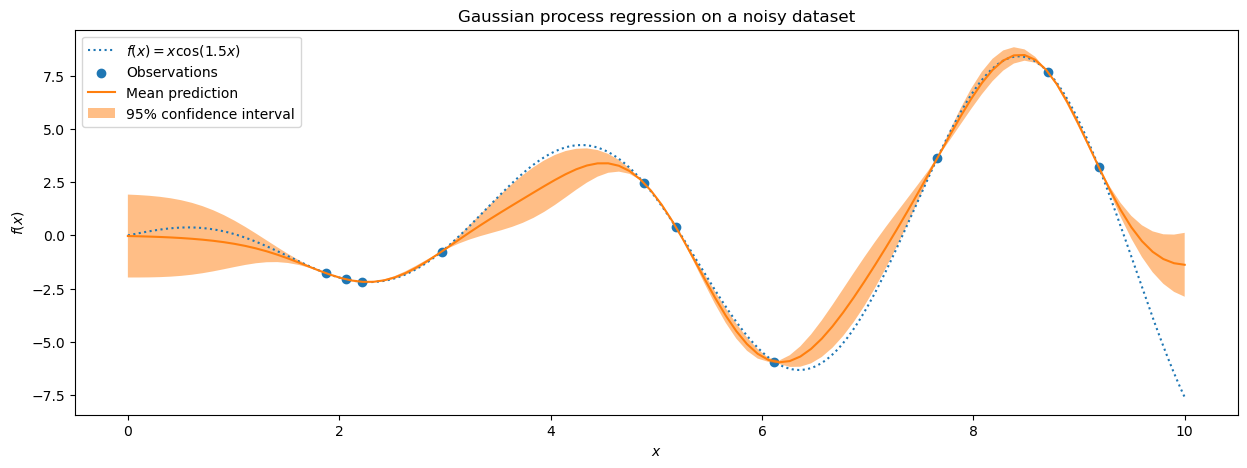

In [6]:

plt.figure(figsize=(15, 5))
plt.plot(X_true, y_true, label=latex_func, linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X_test, mean_prediction, label="Mean prediction")
plt.gca().fill_between(
    X_test.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.title("Gaussian process regression on a noisy dataset")
plt.savefig(figures_path + "gpr.pdf")

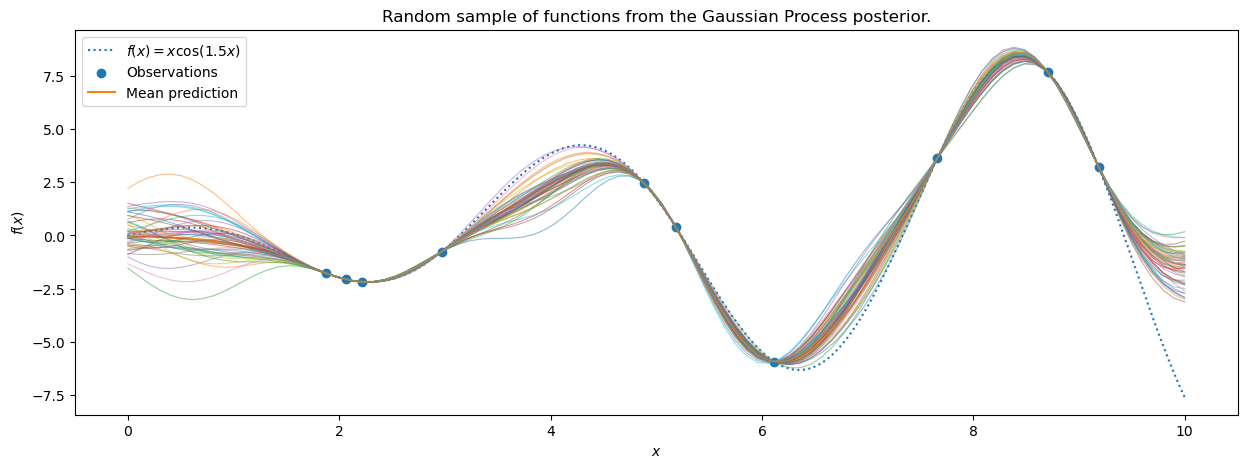

In [7]:
L = np.linalg.cholesky(K_test + 1e-6 * np.eye(n_test) - np.dot(Lk.T, Lk))
f_post = mean_prediction.reshape(-1, 1) + np.dot(L, rng.normal(size=(n_test, 50)))
plt.figure(figsize=(15, 5))
plt.plot(X_true, y_true, label=latex_func, linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X_test, mean_prediction, label="Mean prediction")
plt.plot(X_test, f_post, linewidth=0.8, alpha=0.5)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.title("Random sample of functions from the Gaussian Process posterior.")
plt.savefig(figures_path + "gpr_sample.pdf")